In [4]:
import keras
import pandas as pd
import numpy as np
import glob
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras import models
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.applications import DenseNet169, ResNet50, VGG16, InceptionV3
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import utilities

### Create path to directory

In [10]:
train_dir = 'data_withaug/output/train'
val_dir = 'data_withaug/output/val'
test_dir = 'data_withaug/output/test' 

train_samples =utilities.get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
val_samples = utilities.get_files(val_dir)
test_samples=utilities.get_files(test_dir) 
print(num_classes,"Classes")
print(train_samples,"Train images")
print(val_samples, "Validation images")
print(test_samples,"Test images")

39 Classes
49179 Train images
6139 Validation images
6168 Test images


## Use the ImageDataGenerator from Keras
#### This package in Keras can be used to generate augmented datasets

In [19]:
# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 45,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   brightness_range= [0.9, 1.1],
                                   horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    class_mode='categorical') 


validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')



Found 49179 images belonging to 39 classes.
Found 6139 images belonging to 39 classes.


### Set up architecture for the transfer models.
#### Freeze the transfer model and train the subsequent layers.
Subsequent layers are used to classify the image.

In [29]:
#Replace with any transfer model
base_model = DenseNet169(weights="imagenet", include_top=False,input_shape=(150,150,3))

#Freeze the transfer model in the first pass
for layer in base_model.layers:
    layer.trainable = False
    
#Create architecture for classifying layers.
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(39, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

51879936/51877672 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 4, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                106560    
_________________________________________________________________
dense_5 (Dense)              (None, 39)                2535      
Total params: 12,751,975
Trainable params: 109,095
Non-trainable params: 12,642,880
_________________________________________________________________


In [30]:
batch_size = 32 #the number of training examples used in the estimate of the error
epochs = 10 #number of passes the algorithm will make through the training dataset

In [31]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch= train_samples//batch_size,
    epochs=epochs,
    validation_data=validation_generator)

Epoch 1/10
1536/1536 [==============================] - 4358s 3s/step - loss: 0.6792 - accuracy: 0.8109 - val_loss: 0.3564 - val_accuracy: 0.8811
Epoch 2/10
1536/1536 [==============================] - 4952s 3s/step - loss: 0.2813 - accuracy: 0.9107 - val_loss: 0.2864 - val_accuracy: 0.9107
Epoch 3/10
1536/1536 [==============================] - 4939s 3s/step - loss: 0.2313 - accuracy: 0.9246 - val_loss: 0.2521 - val_accuracy: 0.9205
Epoch 4/10
1536/1536 [==============================] - 3883s 3s/step - loss: 0.2039 - accuracy: 0.9332 - val_loss: 0.2152 - val_accuracy: 0.9308
Epoch 5/10
1536/1536 [==============================] - 3181s 2s/step - loss: 0.1848 - accuracy: 0.9385 - val_loss: 0.2584 - val_accuracy: 0.9184
Epoch 6/10
1536/1536 [==============================] - 3182s 2s/step - loss: 0.1786 - accuracy: 0.9400 - val_loss: 0.2487 - val_accuracy: 0.9231
Epoch 7/10
1536/1536 [==============================] - 3187s 2s/step - loss: 0.1679 - accuracy: 0.9436 - val_loss: 0.2642 -

### First pass: the model is at 94.81% training accuracy and 93.5% validation accuracy.

### Look at train and validation accuracy and loss

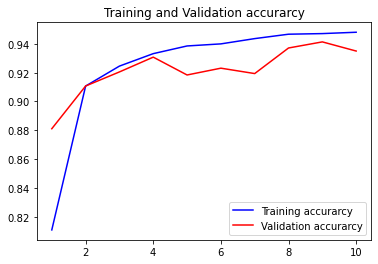

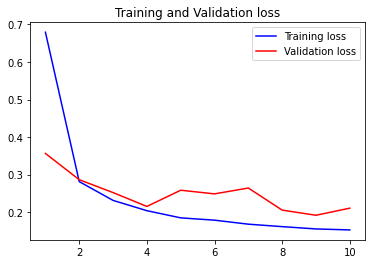

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [34]:
#save model
model.save('./DenseNet169.h5')

In [35]:
#save json file and weights in h5 format
model_json = model.to_json()
with open("DenseNet169.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("DenseNet169_weights.h5")
print("Saved model to disk")

Saved model to disk


In [81]:
#to open model
# json_file = open('baseline.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("baseline.h5")
# print("Loaded model from disk")

## Look at performance on test set

In [36]:
# set up the test set using keras's image data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, # Target directory
    target_size=(150, 150), #Resizes all images to 150 × 150
    batch_size=32,
    shuffle = False,
    class_mode='categorical') #Because you use categorical_crossentropy loss, you need categorical labels

Found 6168 images belonging to 39 classes.


In [37]:
#compile the model
#use evaluate_generator to get the evaluation metrics, specifically accuracy
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.evaluate_generator(test_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
accuracy: 94.26%


#### The test set has an accuracy score of 94.26%

#### Double check results by using the model to make predictions.
Each image is taken in by the model and then probabilities of each class are given to each image. The argmax function returns the class that image has the highest probability of belonging in.

In [120]:
test_generator.reset()

In [121]:
probabilities = model.predict_generator(test_generator)
predicted_class_indices=np.argmax(probabilities,axis=1)

#class_indicies returns the class names
#each true label and predicted label are zipped together
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#create a dataframe with filenames and predictions
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#results are returned in csv format
results.to_csv("results.csv",index=False)

In [127]:
print(train_generator.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___Bacterial_spot': 29, 'Tomato___Early_blight': 30, 'Tomato___Late_blight': 31, 'Tomato___Leaf_Mold': 32, 'Tomato___Septo

In [129]:
#test model on one image
#need to convert the image to an array and into the right dimensions
img = image.load_img('test1.JPG', target_size = (150,150))
y = image.img_to_array(img)
y = np.expand_dims(y, axis = 0)
classes = model.predict_classes(y, batch_size = 10)
print(classes)

[8]


In [15]:
for i, layer in enumerate(dense_loaded_model.layers):
    print(i)
    print(layer.input_shape)
    print(layer.output_shape)

0
(None, 150, 150, 3)
(None, 4, 4, 1664)
1
(None, 4, 4, 1664)
(None, 1664)
2
(None, 1664)
(None, 64)
3
(None, 64)
(None, 39)
